In [56]:
import numpy as np
import pandas as pd
import sympy as sp
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### 📘 Joint Trait Prevalence Estimation

#### 🔹 (a) Unconditional Joint Prevalence $P(A \cap B)$

We estimate the probability of co-occurrence of two traits $A$ and $B$ in the general population using their marginal prevalences and a correlation parameter $r$:

$$
P(A \cap B) \approx P(A) \cdot P(B) + r \cdot \sqrt{P(A)(1 - P(A)) \cdot P(B)(1 - P(B))}
$$

This captures the tendency of traits to co-occur as a function of their individual frequencies and inter-trait correlation.

In [65]:
# -phi_max =< r =< phi_max

# ------------------------------
#  φ range
# ------------------------------
def phi_max_positive(pA, pB):
    return (min(pA, pB) - pA*pB) / np.sqrt(pA*(1-pA)*pB*(1-pB))

def phi_min_negative(pA, pB):
    return (max(0, pA + pB - 1) - pA*pB) / np.sqrt(pA*(1-pA)*pB*(1-pB))


In [66]:
def joint_prevalence(PA, PB, r):
    return PA * PB + r * np.sqrt(PA * (1 - PA) * PB * (1 - PB))

#### 🔹 (b) Conditional Joint Prevalence Given SNP $P(A \cap B \mid \text{SNP})$

We estimate the co-occurrence probability **among SNP carriers** by assuming a correlation between traits *conditional* on genotype. This allows us to relax the independence assumption by introducing a second parameter, $r_{\text{cond}}$, which captures how traits co-occur specifically within the SNP-positive subgroup.

The formula is:

$$
P(A \cap B \mid \text{SNP}) \approx P(A \mid \text{SNP}) \cdot P(B \mid \text{SNP}) + r_{\text{cond}} \cdot \sqrt{P(A \mid \text{SNP})(1 - P(A \mid \text{SNP})) \cdot P(B \mid \text{SNP})(1 - P(B \mid \text{SNP}))}
$$

This formulation allows us to simulate a range of plausible dependence structures within SNP carriers during reverse-inference modeling.

In [67]:
def joint_prevalence_given_snp(PA_snp, PB_snp, rcond):
    return PA_snp * PB_snp + rcond * np.sqrt(PA_snp * (1 - PA_snp) * PB_snp * (1 - PB_snp))

### 📘 Bayesian Inference of $P(\text{SNP} \mid A \cap B)$

We now apply Bayes' theorem to compute the probability of carrying a specific SNP given the co-occurrence of two traits:

$$
P(\text{SNP} \mid A \cap B) = \frac{P(A \cap B \mid \text{SNP}) \cdot P(\text{SNP})}{P(A \cap B)}
$$

This uses the estimates from:

- Step(b): $P(A \cap B \mid \text{SNP})$ — conditional joint prevalence
- Step(a): $P(A \cap B)$ — unconditional joint prevalence
- Input parameter: $P(\text{SNP})$ — SNP frequency in the general population

In [68]:
def p_snp_given_joint(P_joint_given_snp, P_snp, P_joint):
    return (P_joint_given_snp * P_snp) / P_joint

### 📘 trait coexpression enrichment ratio (TCER) Using Background SNP Frequency

We define TCER as the relative odds of carrying a SNP among individuals who have both Trait A and Trait B, compared to the overall population (i.e., unconditional SNP odds).

This provides a conservative estimate of trait-based genetic enrichment:

$$
\text{TCER}_{A \cap B} = \frac{\text{odds}(\text{SNP} \mid A \cap B)}{\text{odds}(\text{SNP})}
$$

Where the odds function is:

$$
\text{odds}(p) = \frac{p}{1 - p}
$$

This version avoids assumptions about trait negativity and allows TCER to be computed using only:

- Posterior $P(\text{SNP} \mid A \cap B)$
- Background SNP frequency $P(\text{SNP})$

In [69]:
def odds(p):
    return p / (1 - p)

def get_tcer(p_snp_given_joint, p_snp_background):
    return odds(p_snp_given_joint) / odds(p_snp_background)

### 🔹 Sensitivity Analysis of TCER with Given Probabilities

We assume the following probabilities are already known from empirical data or reliable estimates:

- $P(A)$: Prevalence of Trait A  
- $P(B)$: Prevalence of Trait B  
- $P(\text{SNP})$: Background SNP frequency  
- $P(A \mid \text{SNP})$: Probability of Trait A given SNP  
- $P(B \mid \text{SNP})$: Probability of Trait B given SNP  

We perform a sensitivity analysis of the trait coexpression enrichment ratio (TCER) by varying:

- $r \in [\phi_{min}, \phi_{max}]$: Trait correlation in the general population  
- $r_{\text{cond}} \in [\phi_{min}^{cond}, \phi_{max}^{cond}]$: Trait correlation among SNP carriers  

The joint probabilities are estimated using:

- General population:
$$
P(A \cap B) = P(A) \cdot P(B) + r \cdot \sqrt{P(A)(1 - P(A))P(B)(1 - P(B))}
$$

- Given SNP:
$$
P(A \cap B \mid \text{SNP}) = P(A \mid \text{SNP}) \cdot P(B \mid \text{SNP}) + r_{\text{cond}} \cdot \sqrt{P(A \mid \text{SNP})(1 - P(A \mid \text{SNP}))P(B \mid \text{SNP})(1 - P(B \mid \text{SNP}))}
$$

Bayes' Theorem gives:
$$
P(\text{SNP} \mid A \cap B) = \frac{P(A \cap B \mid \text{SNP}) \cdot P(\text{SNP})}{P(A \cap B)}
$$

The TCER is then:
$$
\text{TCER} = \frac{\text{odds}(\text{SNP} \mid A \cap B)}{\text{odds}(P(\text{SNP}))}, \quad \text{where} \quad \text{odds}(p) = \frac{p}{1 - p}
$$

This formulation allows us to construct a 2D heatmap of TCER values across the $(r, r_{\text{cond}})$ space, showing the robustness or volatility of SNP inference under trait correlation uncertainty.


### 📘 Sensitivity Analysis with Constrained Correlation Ranges

To ensure realistic and interpretable inference in our reverse SNP estimation model, we impose constraints on the trait correlation parameters `r` and `rcond`. This section explains the motivation and rationale for these constraints.

#### 🔹 Why we impose a structural constraint: `rcond ≥ r - ε` (with ε = 0.1)

To avoid implausible correlation structures, we require that the conditional trait correlation **among SNP carriers** (`rcond`) is not dramatically lower than in the general population (`r`). Specifically:

$$r_{\text{cond}} \geq r - \varepsilon \quad \text{(with } \varepsilon = 0.1 \text{)}$$

**Motivation:**
- If a SNP increases the risk of both Trait A and Trait B, then **SNP-positive individuals should not show unusually low co-occurrence** of those traits.
- Allowing `rcond ≪ r` would imply that **co-occurrence is more likely in the general population than in the SNP-positive subgroup**, which is biologically implausible.

**Epsilon (ε) = 0.1** is a conservative margin that avoids extreme asymmetry while allowing moderate variation in trait correlation.

---

#### ✅ Practical Summary

- Restricting `r` and `rcond` helps avoid unrealistic inferences in sensitivity analysis.
- The condition `rcond ≥ r - ε` ensures structural consistency with the assumption of shared genetic risk.
- With these constraints, we obtain more reliable estimates of **minimum TCER**, representing conservative enrichment under phenotypic co-occurrence.



### 🔹 TCER Range Summary

After sweeping $r \in [min, max]$ and $r_{\text{cond}} \in [min, max]$, we identify the bounds of the trait coexpression enrichment ratio (TCER):

- **Minimum TCER**:  
Occurs at $(r, r_{\text{cond}}) = (\text{min}_r, \text{min}_{r_{\text{cond}}})$  
$$
\text{TCER}_{\min} = \frac{\text{odds}(\text{SNP} \mid A \cap B)}{\text{odds}(P(\text{SNP}))}
$$

- **Maximum TCER**:  
Occurs at $(r, r_{\text{cond}}) = (\text{max}_r, \text{max}_{r_{\text{cond}}})$
$$
\text{TCER}_{\max} = \frac{\text{odds}(\text{SNP} \mid A \cap B)}{\text{odds}(P(\text{SNP}))}
$$

These extrema provide the lower and upper bounds of the inferred SNP enrichment based on phenotypic co-occurrence, under uncertainty about trait correlations.


rmax  0.7503640398231217
rmin  -0.16471405752214865
rcondmax  0.5412126976836508
rcondmin  -0.8715064296555579


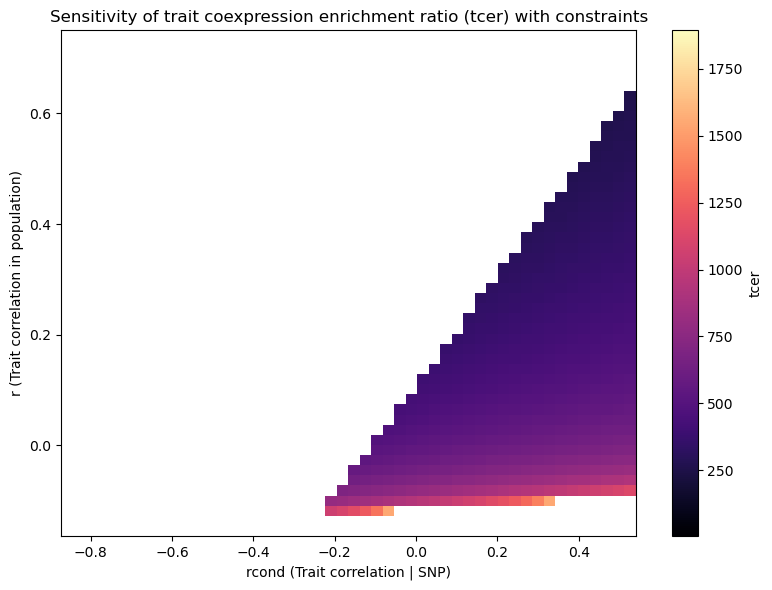

🧭 realistic TCER: 3.52（r = 0.64, rcond = 0.54）


In [74]:
# input
P_A = 0.11
P_B = 0.18
P_SNP = 0.024
P_A_SNP = 0.6169
P_B_SNP = 0.3205

r_max = phi_max_positive(P_A, P_B)
r_min = phi_min_negative(P_A, P_B)
r_cond_max = phi_max_positive(P_A_SNP, P_B_SNP)
r_cond_min = phi_min_negative(P_A_SNP, P_B_SNP)

# param
epsilon = 0.1
r_vals = np.linspace(r_min, r_max, 50)        # correlation within general population
rcond_vals = np.linspace(r_cond_min, r_cond_max, 50)    # correlation within SNP-positiive population
tcer_matrix_filtered = np.full((len(r_vals), len(rcond_vals)), np.nan)
print("rmax ", r_max)
print("rmin ", r_min)
print("rcondmax ",r_cond_max)
print("rcondmin ", r_cond_min)

for i, r in enumerate(r_vals):
    for j, rcond in enumerate(rcond_vals):

        if rcond < r - epsilon:
            continue

        P_joint = joint_prevalence(P_A, P_B, r)
        if not (0 < P_joint < 1):
            continue

        P_joint_snp = joint_prevalence_given_snp(P_A_SNP, P_B_SNP, rcond)
        P_post = p_snp_given_joint(P_joint_snp, P_SNP, P_joint)
        if not (0 < P_post < 1): 
            continue

        tcer_matrix_filtered[i, j] = get_tcer(P_post, P_SNP)


# heatmap
plt.figure(figsize=(8, 6))
plt.imshow(tcer_matrix_filtered, extent=[rcond_vals.min(), rcond_vals.max(), r_vals.min(), r_vals.max()], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label='tcer')
plt.xlabel('rcond (Trait correlation | SNP)')
plt.ylabel('r (Trait correlation in population)')
plt.title('Sensitivity of trait coexpression enrichment ratio (tcer) with constraints')
plt.tight_layout()
masked = np.ma.masked_invalid(tcer_matrix_filtered)  # NaN をマスク
plt.imshow(
    masked,
    extent=[rcond_vals.min(), rcond_vals.max(), r_vals.min(), r_vals.max()],
    origin='lower',
    aspect='auto',
    cmap='magma',
    norm=LogNorm(vmin=1, vmax=1e4)
)

plt.show()

# search for min
min_tcer = np.nanmin(tcer_matrix_filtered)
min_index = np.unravel_index(np.nanargmin(tcer_matrix_filtered), tcer_matrix_filtered.shape)
min_r, min_rcond = r_vals[min_index[0]], rcond_vals[min_index[1]]

# output
print(f"🧭 realistic TCER: {min_tcer:.2f}（r = {min_r:.2f}, rcond = {min_rcond:.2f}）")


### Test run with actual data

In [77]:
# Functions used in TCER calculation

def p_trait_given_snp(OR_val, PS_val, PT_val):
    w = sp.Symbol('w', real=True)
    PS = sp.Symbol('PS', real=True)
    PT = sp.Symbol('PT', real=True)
    OR = sp.Symbol('OR', real=True)

    expr = sp.Eq(OR, (w * (1 - PS - PT + w)) / ((PS - w) * (PT - w)))
    solutions = sp.solve(expr, w)
    numeric_solutions = [sol.evalf(subs={OR: OR_val, PS: PS_val, PT: PT_val}) for sol in solutions]

    valid_solutions = []
    for sol in numeric_solutions:
        if sol.is_real and 0 <= sol <= min(PS_val, PT_val):
            p_trait_given_snp = float(sol) / PS_val
            valid_solutions.append(round(p_trait_given_snp, 6))
    return valid_solutions

def joint_prevalence(PA, PB, r):
    return PA * PB + r * np.sqrt(PA * (1 - PA) * PB * (1 - PB))

def joint_prevalence_given_snp(PA_snp, PB_snp, rcond):
    return PA_snp * PB_snp + rcond * np.sqrt(PA_snp * (1 - PA_snp) * PB_snp * (1 - PB_snp))

def odds(p):
    return p / (1 - p) if p < 1 else np.inf

def get_tcer(post, prior):
    return odds(post) / odds(prior)

def compute_TCER_CI_from_given_Ps(PA_given_SNP, PB_given_SNP, P_SNP, P_A, P_B, r, rcond):
    joint_given_snp = joint_prevalence_given_snp(PA_given_SNP, PB_given_SNP, rcond)
    joint_uncond = joint_prevalence(P_A, P_B, r)
    if joint_uncond <= 0 or joint_uncond >= 1:
        return None
    P_snp_given_joint = (joint_given_snp * P_SNP / joint_uncond)
    if not (0 < P_snp_given_joint < 1):
        return None
    tcer = round(get_tcer(P_snp_given_joint, P_SNP), 2)
    return tcer

# Constants
P_SNP = 0.024
P_AD = 0.11
P_DLP = 0.18
OR_AD = 14.9
OR_DLP = 2.2


# Get P(trait | SNP)
P_AD_given_SNP = p_trait_given_snp(OR_AD, P_SNP, P_AD)[0]
P_DLP_given_SNP = p_trait_given_snp(OR_DLP, P_SNP, P_DLP)[0]

# Sweep ranges
r_vals = np.linspace(phi_min_negative(P_AD, P_DLP), phi_max_positive(P_AD, P_DLP), 30)
rcond_vals = np.linspace(phi_min_negative(P_AD_given_SNP, P_DLP_given_SNP),
                         phi_max_positive(P_AD_given_SNP, P_DLP_given_SNP), 30)

# Run sweep with constraint rcond >= r - epsilon
epsilon = 0.1
valid_results = []

for r in r_vals:
    for rcond in rcond_vals:
        if rcond < r - epsilon:
            continue
        tcer = compute_TCER_CI_from_given_Ps(
            P_AD_given_SNP, P_DLP_given_SNP,
            P_SNP, P_AD, P_DLP,
            r=r, rcond=rcond
        )
        if tcer is not None:
            valid_results.append({
                "r": round(r, 3),
                "rcond": round(rcond, 3),
                "tcer": tcer
            })

df_tcer_valid = pd.DataFrame(valid_results)
df_tcer_valid

,r,rcond,tcer
0,-0.133,-0.190,1894.17
1,-0.102,-0.190,38.99
2,-0.102,-0.141,44.85
3,-0.102,-0.092,51.64
4,-0.102,-0.043,59.59
...,...,...,...
194,0.529,0.541,4.13
195,0.561,0.492,3.78
196,0.561,0.541,3.93
197,0.593,0.541,3.75


# 🔍 Should We Sweep Both $r$ and $r_{\text{cond}}$?

## 🧩 Parameter Roles and Differences

| Parameter | Sweep? | Why Sweep It? | Sweep Range |
|-----------|--------|---------------|-------------|
| $$r$$ *(Population-level trait correlation)* | ✅ Yes | Trait-trait correlation in the general population is typically unknown and affects joint trait prevalence. | $$r ∈ [φ_{min}, φ_{max}]$$ |
| $$r_{\text{cond}}$$ *(conditional (SNP-positive) trait correlation)* | ✅ Yes | Determines co-expression of traits among SNP carriers; must be assumed or bounded. | $$r_{\text{cond}} ∈ [φ_{min}^{\text{SNP}}, φ_{max}^{\text{SNP}}]$$ |

---

## 🎯 Why Sweep r_cond?

- r_cond cannot be directly observed without large SNP-stratified samples.
- Sweeping it independently from `r` captures plausible variation in **within-genotype phenotypic structure**.
- It allows us to compute **TCER bounds** under different co-expression hypotheses.

---

## 🧪 2D Sensitivity Sweep

1. **Sweep `r`** across `[φ_{min}, φ_{max}]` to vary **unconditional trait dependence**.
2. For each `r`, independently sweep `r_{\text{cond}}` across `[φ_{min}^{(SNP)}, φ_{max}^{(SNP)}]`.
3. Compute:
   - `P(A ∩ B)`
   - `P(A ∩ B | SNP)`
   - `P(SNP | A ∩ B)`
   - `TCER = odds(P(SNP | A ∩ B)) / odds(P(SNP))`
4. Visualize TCER as a function over the `(r, r_{\text{cond}})` grid.

---

## ⚠️ Optional Structural Constraint

To ensure biological plausibility, we may optionally enforce:

$$r_{\text{cond}} ≥ r − ε$$
